In [16]:
# === Core Utilities ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display, Markdown

# === RDKit: Molecular Handling ===
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit import RDLogger

# === Scikit-learn: ML Tools ===
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, f1_score
)
from sklearn.model_selection import (
    GridSearchCV, cross_val_score, train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight

# === XGBoost ===
from xgboost import XGBClassifier


# ✅ Data Loading & Merging

 **The following section loads six QS inhibitor datasets (LasR and LuxR), applies naming consistency, and merges them into a single dataframe for downstream analysis.**
                                                            

In [17]:
"""Merge Quorum Sensing (QS) inhibitor datasets from multiple CSVs into a single DataFrame."""

import pandas as pd

# Define dataset paths (relative to project root)
file_paths = {
    "LasR": "./Data_QS_Inhibitors/LasR_inhibitors.csv",
    "LuxR": "./Data_QS_Inhibitors/LuxR_inhibitors.csv"
}  # ← this closing brace was missing

# Map verbose receptor names to standard names
RECEPTOR_NAME_MAP = {
    "Transcriptional activator protein lasR": "LasR",
    "Transcriptional activator protein luxR": "LuxR",
}

# Load individual CSVs into a dictionary of DataFrames
dfs = {}
for name, path in file_paths.items():
    try:
        dfs[name] = pd.read_csv(path, delimiter=";")  # Semicolon-delimited CSVs
    except FileNotFoundError:
        print(f"❌ Error: {path} not found. Please check the Data_QS_Inhibitors directory.")
        raise

# Merge all receptor DataFrames into one
df_merged = pd.concat(dfs.values(), ignore_index=True)

# Standardize receptor names
df_merged["Target Name"] = df_merged["Target Name"].replace(RECEPTOR_NAME_MAP)

# Preview and save the merged dataset
print("✅ Fixed Unique QS Receptors:", df_merged["Target Name"].unique())
print(f"✅ Merged dataset shape: {df_merged.shape}")


✅ Fixed Unique QS Receptors: ['LasR' 'LuxR']
✅ Merged dataset shape: (264, 48)


In [18]:
"""Explore the merged QS inhibitor dataset before splitting."""

# Inspect the dataset
print("Sample rows from merged dataset:")
print(df_merged.head())  # Display first 5 rows

print("\nColumn names:")
print(df_merged.columns.tolist())  # List all columns as a readable list

print("\nData types and null counts:")
print(df_merged.info())  # Show data types and missing values

print("\nClass distribution for Target Name:")
print(df_merged["Target Name"].value_counts())  # Check distribution of receptor names


Sample rows from merged dataset:
  Molecule ChEMBL ID Molecule Name  Molecule Max Phase  Molecular Weight  \
0      CHEMBL1814830           NaN                 NaN            187.26   
1      CHEMBL1812088           NaN                 NaN            311.41   
2      CHEMBL1812091           NaN                 NaN            288.37   
3      CHEMBL1812109           NaN                 NaN            403.95   
4      CHEMBL1812119           NaN                 NaN            221.26   

   #RO5 Violations  AlogP Compound Key  \
0                0   0.93           19   
1                0   3.04           32   
2                0   2.25           35   
3                1   5.78           21   
4                0   0.91           32   

                                         Smiles Standard Type  \
0                        CCCC(=O)N[C@H]1CCSC1=O    Inhibition   
1           O=C(Cc1ccc(-c2ccccc2)cc1)NC1CCSC1=O    Inhibition   
2         O=C(CCc1cc2ccccc2[nH]1)N[C@H]1CCSC1=O    Inhibition 

In [19]:
"""Select relevant columns for the working dataset."""

# Define columns to keep
columns_to_keep = [
    "Molecule ChEMBL ID",  # Unique molecule identifier
    "Smiles",             # Molecular structure in SMILES format
    "Standard Value",     # Activity measurement (e.g., IC50)
    "Target Name",        # Receptor name (target variable)
    "Target ChEMBL ID"    # Unique target identifier
]

# Create working dataset with selected columns
df_working = df_merged[columns_to_keep].copy()

# Quick check
print(f"✅ Working dataset shape: {df_working.shape}")

✅ Working dataset shape: (264, 5)


In [20]:
# Inspect missing values
missing_count = df_working["Standard Value"].isna().sum()
total = df_working.shape[0]
print(f"Missing inhibition values: {missing_count} / {total} ({missing_count/total:.2%})")

# Show which receptors are missing most
print(df_working[df_working["Standard Value"].isna()]["Target Name"].value_counts())



Missing inhibition values: 65 / 264 (24.62%)
Target Name
LasR    52
LuxR    13
Name: count, dtype: int64


In [21]:
# Drop rows with missing Standard Value
df_working = df_working.dropna(subset=["Standard Value"])
# Double-check that missing values are gone
print(df_working["Standard Value"].isna().sum())
#df_working.to_csv("QS_Inhibitors_Final.csv", index=False)
# Inspect the dataset
print("Sample rows from merged dataset:")
print(df_working.head())  # Display first 5 rows

print("\nColumn names:")
print(df_working.columns.tolist())  # List all columns as a readable list

print("\nData types and null counts:")
print(df_working.info())  # Show data types and missing values

print("\nClass distribution for Target Name:")
print(df_working["Target Name"].value_counts())  # Check distribution of receptor names
# Check for duplicates based on SMILES and Receptor
duplicates = df_working[df_working.duplicated(subset=['Smiles', 'Target Name'], keep=False)]

# Show how many and what they are
# Sort duplicates by Molecule ChEMBL ID
duplicates_sorted = duplicates.sort_values(by='Molecule ChEMBL ID')

# Show the sorted duplicates
print(f"Number of duplicated drug-target pairs: {len(duplicates_sorted)}")
display(duplicates_sorted)




0
Sample rows from merged dataset:
  Molecule ChEMBL ID                                        Smiles  \
0      CHEMBL1814830                        CCCC(=O)N[C@H]1CCSC1=O   
1      CHEMBL1812088           O=C(Cc1ccc(-c2ccccc2)cc1)NC1CCSC1=O   
2      CHEMBL1812091         O=C(CCc1cc2ccccc2[nH]1)N[C@H]1CCSC1=O   
3      CHEMBL1812109  CCCCCCCCCC(=O)CC(=O)Nc1cc(-c2ccc(Cl)cc2)nn1C   
4      CHEMBL1812119                      CCOC(=O)CNC(=O)Cc1ccccc1   

   Standard Value Target Name Target ChEMBL ID  
0           -24.0        LasR    CHEMBL1075207  
1           -23.0        LasR    CHEMBL1075207  
2            -7.0        LasR    CHEMBL1075207  
3             0.0        LasR    CHEMBL1075207  
4           -10.0        LasR    CHEMBL1075207  

Column names:
['Molecule ChEMBL ID', 'Smiles', 'Standard Value', 'Target Name', 'Target ChEMBL ID']

Data types and null counts:
<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, 0 to 262
Data columns (total 5 columns):
 #   Column          

,Molecule ChEMBL ID,Smiles,Standard Value,Target Name,Target ChEMBL ID
240,CHEMBL2063564,CCCCc1cn(C2CCOC2=O)nn1,27.90,LuxR,CHEMBL5351
239,CHEMBL2063564,CCCCc1cn(C2CCOC2=O)nn1,22.50,LuxR,CHEMBL5351
163,CHEMBL2063564,CCCCc1cn(C2CCOC2=O)nn1,19.90,LuxR,CHEMBL5351
174,CHEMBL2063564,CCCCc1cn(C2CCOC2=O)nn1,12.70,LuxR,CHEMBL5351
230,CHEMBL2063565,CCCCCc1cn(C2CCOC2=O)nn1,35.10,LuxR,CHEMBL5351
222,CHEMBL2063565,CCCCCc1cn(C2CCOC2=O)nn1,9.00,LuxR,CHEMBL5351
175,CHEMBL2063565,CCCCCc1cn(C2CCOC2=O)nn1,21.30,LuxR,CHEMBL5351
171,CHEMBL2063565,CCCCCc1cn(C2CCOC2=O)nn1,27.50,LuxR,CHEMBL5351
241,CHEMBL2063566,CCCCCCc1cn(C2CCOC2=O)nn1,11.60,LuxR,CHEMBL5351
229,CHEMBL2063566,CCCCCCc1cn(C2CCOC2=O)nn1,19.90,LuxR,CHEMBL5351


##   Exploratory Data Analysis: Inhibition % Distribution

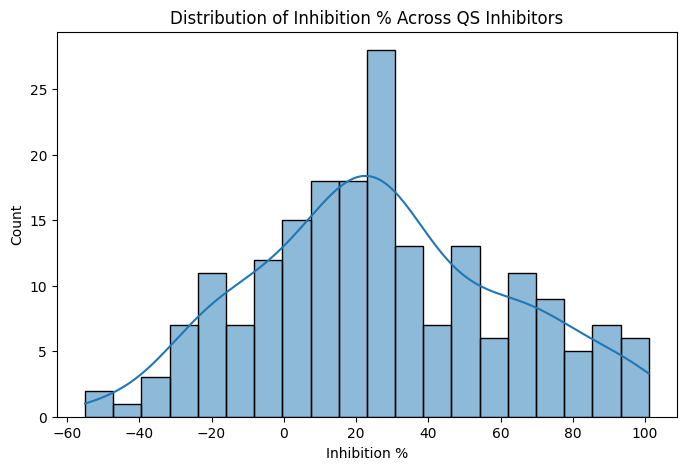

In [366]:
"""Visualize the distribution of inhibition %"""
plt.figure(figsize=(8, 5))
sns.histplot(df_working["Standard Value"], bins=20, kde=True)
plt.xlabel("Inhibition %")
plt.ylabel("Count")
plt.title("Distribution of Inhibition % Across QS Inhibitors")
plt.show()


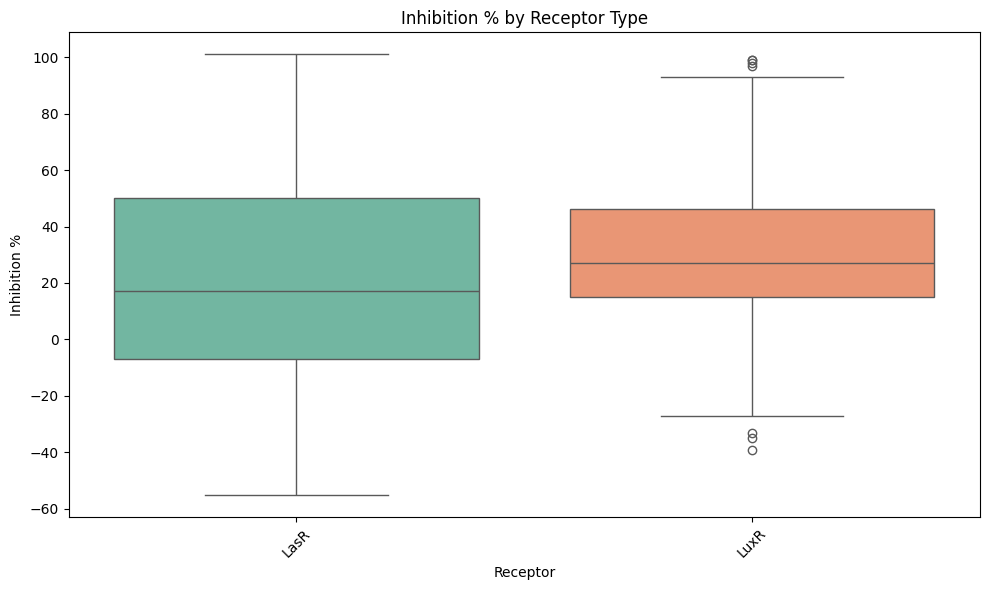

In [22]:
"""Visualize the distribution of inhibition % across different receptors"""
plt.figure(figsize=(10, 6)) 
sns.boxplot(
    data=df_working,
    x="Target Name", 
    y="Standard Value", 
    hue="Target Name", 
    dodge=False, 
    palette="Set2",
    legend=False
)
plt.xlabel("Receptor")
plt.ylabel("Inhibition %")
plt.title("Inhibition % by Receptor Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# ✅ Data Cleaning
**Select relevant columns, rename for consistency, 
drop missing values, 
combine duplicants by replacing the inhibition percent by the mean, and 
create binary and multi-class labels for inhibition activity.**


In [23]:
def Cleaning_qs_data(df_working):
    """
    Cleans and formats the QS inhibitors dataset.
    - Keeps only relevant columns
    - Converts inhibition values to numeric
    - Drops missing inhibition values
    - Averages inhibition % for duplicate SMILES+Receptor pairs
    - Creates binary and multi-class activity labels
    """

    # Select relevant columns
    df = df_working[["Molecule ChEMBL ID", "Smiles", "Standard Value", "Target Name", "Target ChEMBL ID"]].copy()

    # Rename columns for consistency
    df.rename(columns={
        "Smiles": "SMILES",
        "Standard Value": "Inhibition %",
        "Target Name": "Receptor",
        "Target ChEMBL ID": "Receptor ChEMBL ID"
    }, inplace=True)

    # Convert inhibition values to numeric
    df["Inhibition %"] = pd.to_numeric(df["Inhibition %"], errors="coerce")

    # Drop rows with missing inhibition values
    df.dropna(subset=["Inhibition %"], inplace=True)

    # Average inhibition % for duplicate SMILES+Receptor combinations
    df = df.groupby(['SMILES', 'Receptor'], as_index=False).agg({
        'Inhibition %': 'mean',
        'Molecule ChEMBL ID': 'first',
        'Receptor ChEMBL ID': 'first'
    })

    # Binary Classification: Active vs. Inactive
    df["Active"] = (df["Inhibition %"] >= 0).astype(int)

    # Three-Way Classification: Negative, Weak, Strong
    df["Activity Level"] = pd.cut(
        df["Inhibition %"], 
        bins=[-float("inf"), 0, 50, float("inf")],  # Define ranges
        labels=[0, 1, 2]  # 0 = Negative, 1 = Weak, 2 = Strong
    ).astype(int)  # Ensure it's integer type

    # Save cleaned dataset
    df.to_csv("QS_Inhibitors_Cleaned.csv", index=False)

    print(f"✅ Cleaned dataset shape: {df.shape}")
    print(f"✅ Available columns after processing: {df.columns.tolist()}")

    return df
# Apply preprocessing
df_cleaned = Cleaning_qs_data(df_merged)

✅ Cleaned dataset shape: (168, 7)
✅ Available columns after processing: ['SMILES', 'Receptor', 'Inhibition %', 'Molecule ChEMBL ID', 'Receptor ChEMBL ID', 'Active', 'Activity Level']


In [28]:
# Display basic info
print(df_cleaned.info())

# Check for any remaining missing values
print("# of Nans", df_cleaned.isna().sum())

# Summary statistics
print(df_cleaned.describe())

# Check unique inhibition % values
print("Inhibition % range:", df_cleaned["Inhibition %"].min(), "to", df_cleaned["Inhibition %"].max())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SMILES              168 non-null    object 
 1   Receptor            168 non-null    object 
 2   Inhibition %        168 non-null    float64
 3   Molecule ChEMBL ID  168 non-null    object 
 4   Receptor ChEMBL ID  168 non-null    object 
 5   Active              168 non-null    int64  
 6   Activity Level      168 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 9.3+ KB
None
# of Nans SMILES                0
Receptor              0
Inhibition %          0
Molecule ChEMBL ID    0
Receptor ChEMBL ID    0
Active                0
Activity Level        0
dtype: int64
       Inhibition %      Active  Activity Level
count    168.000000  168.000000      168.000000
mean      26.293006    0.744048        0.976190
std       36.699285    0.437700        0.725518
min  

In [37]:
df_cleaned = pd.read_csv("QS_Inhibitors_Cleaned.csv")
num_unique_drugs = df_cleaned["Molecule ChEMBL ID"].nunique()
print(f"🔹 Number of unique drugs: {num_unique_drugs}")
num_unique_smiles = df_cleaned["SMILES"].nunique()
print(f"🔹 Number of unique SMILES: {num_unique_smiles}")


🔹 Number of unique drugs: 115
🔹 Number of unique SMILES: 115


In [49]:
# Count how many receptors each drug is tested on
drug_receptor_counts = df_cleaned.groupby("Molecule ChEMBL ID")["Receptor"].nunique()
multi_target_drugs = drug_receptor_counts[drug_receptor_counts > 1]

print(f"🔸 Number of drugs tested on multiple receptors: {len(multi_target_drugs)}")
display(multi_target_drugs.head())


🔸 Number of drugs tested on multiple receptors: 53


Molecule ChEMBL ID
CHEMBL1562015    2
CHEMBL1722026    2
CHEMBL1812080    2
CHEMBL1812081    2
CHEMBL1812082    2
Name: Receptor, dtype: int64

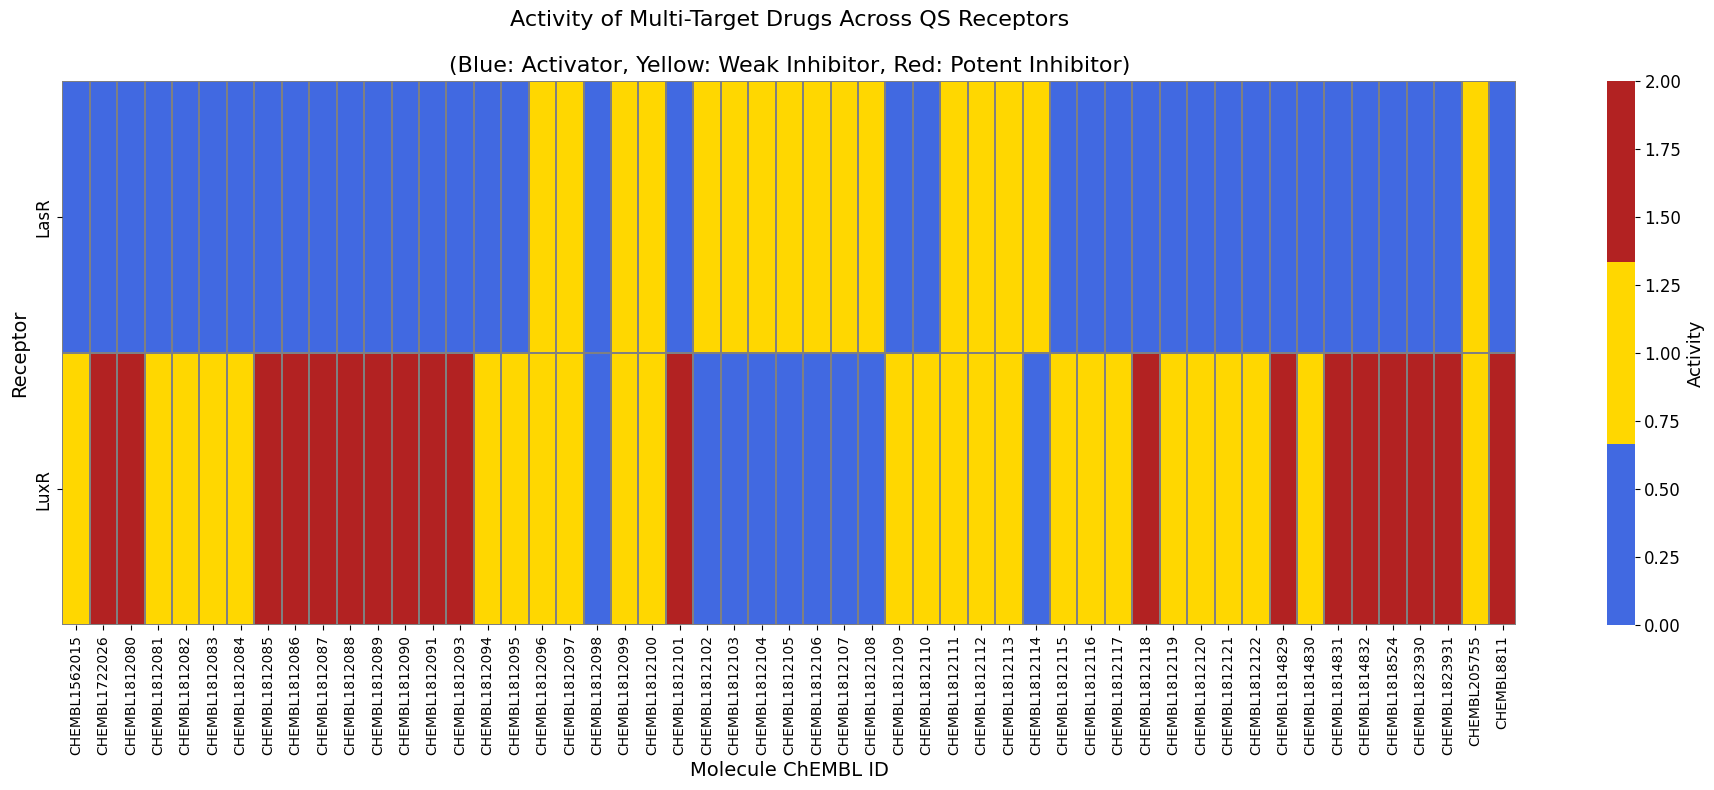

In [52]:
# Filter for drugs tested on multiple receptors
multi_target_drugs = df_cleaned["Molecule ChEMBL ID"].isin(drug_receptor_counts[drug_receptor_counts > 1].index)
filtered_df = df_cleaned[multi_target_drugs]
filtered_df = df_cleaned[multi_target_drugs]
# Pivot to create matrix for heatmap
heatmap_df = filtered_df.pivot(index="Receptor", columns="Molecule ChEMBL ID", values="Activity Level")

# Plot
plt.figure(figsize=(19, 8))
ax = sns.heatmap(
    heatmap_df,
    cmap=sns.color_palette(["royalblue", "gold", "firebrick"]),
    linewidths=0.2,
    linecolor='gray',
    cbar_kws={"label": "Activity Level"},
    square=False
)

# Labels & styling
ax.set_title("Activity of Multi-Target Drugs Across QS Receptors\n \n(Blue: Activator, Yellow: Weak Inhibitor, Red: Potent Inhibitor)", fontsize=16)
ax.set_xlabel("Molecule ChEMBL ID", fontsize=14)
ax.set_ylabel("Receptor", fontsize=14)
ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=12)

# Colorbar formatting
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Activity", fontsize=13)

plt.tight_layout()
plt.show()



**Some molecules show strong inhibition for one LuxR-type receptor but are weak or even activating for lasR. This suggests receptor-specific effects, or possibly noise/artifacts in inhibition measurements.**


# ✅ Train-Test Split

**Split the cleaned dataset into training and testing sets using an 80/20 ratio.  
Only SMILES and Receptor are used as input features, and the multi-class `Activity Level` is used as the target.**


In [53]:
#####Split dataset into train and test set#############

# Load the cleaned dataset
df_cleaned = pd.read_csv("QS_Inhibitors_Cleaned.csv")

# Define features and target
X = df_cleaned[["SMILES", "Receptor"]].copy()        # Only keep SMILES + receptor
y = df_cleaned["Activity Level"]                        # Raw inhibition percentage


X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,      # ✅ Keep class distribution consistent
    random_state=42
)


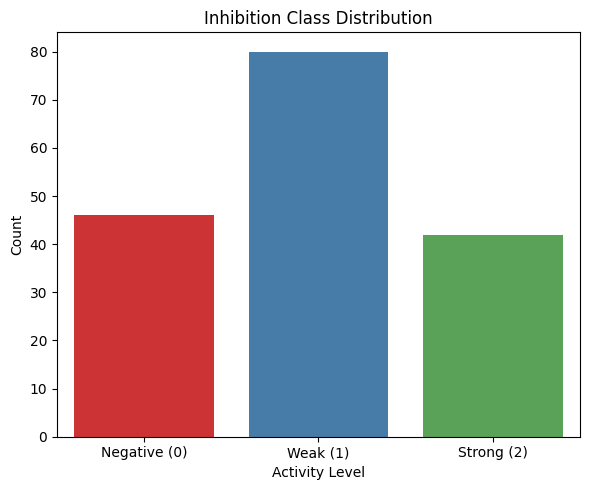

In [54]:

# Plot class distribution
plt.figure(figsize=(6, 5))
ax = sns.countplot(
    x="Activity Level", 
    data=df_cleaned, 
    hue="Activity Level",     # Required for separate colors
    palette="Set1", 
    dodge=False
)

ax.legend_.remove()  # Clean up redundant legend
ax.set_title("Inhibition Class Distribution")
ax.set_ylabel("Count")
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Negative (0)", "Weak (1)", "Strong (2)"])
plt.tight_layout()
plt.show()



# ✅ Feature Engineering & Preprocessing Pipeline

SMILES → Fingerprints using RDKit

Receptor Encoding via one-hot encoding





In [57]:
# Silence RDKit warnings
#RDLogger.DisableLog('rdApp.*')


############## 1. SMILES → Fingerprint Transformer ##############

class SmilesFingerprintTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, radius=2, n_bits=512):
        self.radius = radius
        self.n_bits = n_bits

    def smiles_to_fingerprint(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, self.n_bits))
        else:
            return [0] * self.n_bits  # fallback if SMILES parsing fails

    def fit(self, X, y=None):
        return self  # stateless

    def transform(self, X):
        fps = X["SMILES"].apply(self.smiles_to_fingerprint)
        return pd.DataFrame(fps.tolist(), index=X.index)


############## 2. Receptor → One-Hot Encoder ##############

class ReceptorEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

    def fit(self, X, y=None):
        self.encoder.fit(X[["Receptor"]])
        return self

    def transform(self, X):
        transformed = self.encoder.transform(X[["Receptor"]])
        return pd.DataFrame(transformed, columns=self.encoder.get_feature_names_out(["Receptor"]), index=X.index)


############## 3. Build Feature Union ##############

def build_feature_pipeline():
    return FeatureUnion([
        ("smiles_fp", SmilesFingerprintTransformer()),
        ("receptor_ohe", ReceptorEncoder())
    ])



In [63]:

# Build and fit the pipeline
feature_pipeline = build_feature_pipeline()
X_train_transformed = feature_pipeline.fit_transform(X_train)
X_test_transformed = feature_pipeline.transform(X_test)
# 2. Reconstruct DataFrames with column names
fp_cols = [f"FP_{i}" for i in range(512)]
receptor_cols = feature_pipeline.transformer_list[1][1].encoder.get_feature_names_out(["Receptor"])
all_feature_names = list(fp_cols) + list(receptor_cols)

X_train_transformed = pd.DataFrame(X_train_transformed, columns=all_feature_names, index=X_train.index)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=all_feature_names, index=X_test.index)


##  Fingerprint Bit Distribution
**Distribution of ON fingerprint bits across all molecules. Most bits are rarely activated, reflecting the sparsity of Morgan fingerprints**

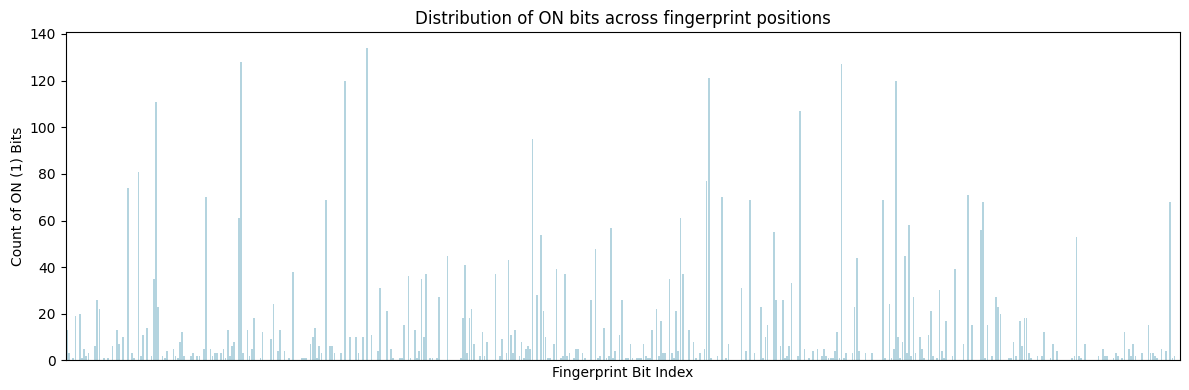

In [60]:
fingerprints_train = X_train_transformed.iloc[:, :512]  # first 512 cols are fingerprints

bit_counts = fingerprints_train.sum(axis=0)

plt.figure(figsize=(12, 4))
sns.barplot(x=bit_counts.index, y=bit_counts.values, color='lightblue')
plt.title("Distribution of ON bits across fingerprint positions")
plt.xlabel("Fingerprint Bit Index")
plt.ylabel("Count of ON (1) Bits")
plt.xticks([], [])  # hide tick labels for clarity
plt.tight_layout()
plt.show()


## Fingerprint Heatmap (First 50 Molecules)
**Each row is a molecule, each column is a fingerprint bit. The sparse structure shows high diversity in substructures across compounds.**

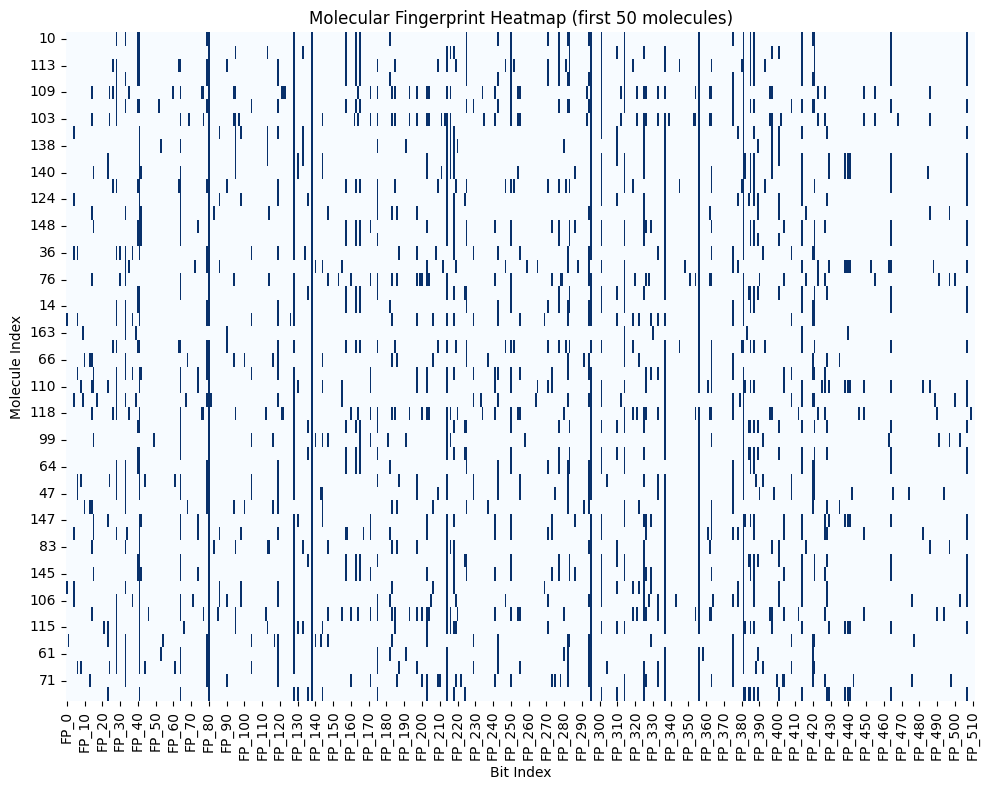

In [61]:
plt.figure(figsize=(10, 8))
sns.heatmap(fingerprints_train.iloc[:50], cmap="Blues", cbar=False)
plt.title("Molecular Fingerprint Heatmap (first 50 molecules)")
plt.xlabel("Bit Index")
plt.ylabel("Molecule Index")
plt.tight_layout()
plt.show()


# Analyzing Feature Variance with PCA


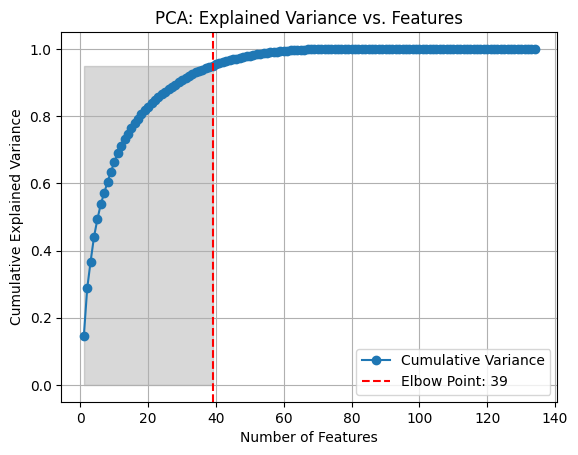

**📌 ~39 features explain 95% of the variance**

In [64]:
from sklearn.decomposition import PCA

def plot_pca_variance(X_train):
    """Plots PCA cumulative explained variance."""
    pca = PCA()
    pca.fit(X_train_transformed)
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    elbow_point = np.argmax(cumulative_variance >= 0.95) + 1
    
    plt.figure()
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label="Cumulative Variance")
    plt.axvline(x=elbow_point, color='r', linestyle='--', label=f"Elbow Point: {elbow_point}")
    plt.fill_between(range(1, elbow_point + 1), 0, cumulative_variance[elbow_point - 1], color='gray', alpha=0.3)
    
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA: Explained Variance vs. Features')
    plt.legend()
    plt.grid()
    plt.show()
    
    return elbow_point

# Run PCA for variance exploration only
elbow_point = plot_pca_variance(X_train_transformed)
display(Markdown(f"**📌 ~{elbow_point} features explain 95% of the variance**"))



## ✅ Feature Selection via Random Forest Importance (Top 20 Features)


In [65]:

# Function to select select top 20 features using RF feature importance######
def get_top_rf_features(X_train, y, N, filename):
    """
    Trains a Random Forest classifier and selects top N features by importance.
    Saves the selected features to a CSV file.

    Args:
        X_train (DataFrame): Training features.
        y_train (Series): Training labels.
        N (int): Number of top features to select.
        filename (str): File name to save the selected features.

    Returns:
        selected_features (list): List of top N feature names.
    """
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf.fit(X_train, y_train)

    # Feature Importance
    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    })

    # Sort and select the top N features
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False).head(N)
    selected_features = feature_importances['Feature'].tolist()

    # Save to file
    feature_importances.to_csv(filename, index=False)
    print(f"✔️ Top {N} features saved to {filename}")

    return selected_features

# Specify the number of features to select
N = 20
# Adjust as needed

# Train RF and get top features
rf_selected_features = get_top_rf_features(X_train_transformed, y_train, N, "QS_Inhibitors_rf_selected_features.csv")

# Keep only the selected features
X_train_selected_RF = X_train_transformed[rf_selected_features]
X_test_selected_RF = X_test_transformed[rf_selected_features]

# Print results
print(" 📍Selected Features:", rf_selected_features)
print(f" X_train shape after selection: {X_train_selected_RF.shape}")
print(f" X_test shape after selection: {X_test_selected_RF.shape}")




✔️ Top 20 features saved to QS_Inhibitors_rf_selected_features.csv
 📍Selected Features: ['Receptor_LasR', 'Receptor_LuxR', 'FP_144', 'FP_119', 'FP_40', 'FP_42', 'FP_6', 'FP_319', 'FP_165', 'FP_163', 'FP_280', 'FP_250', 'FP_414', 'FP_218', 'FP_41', 'FP_277', 'FP_310', 'FP_333', 'FP_225', 'FP_314']
 X_train shape after selection: (134, 20)
 X_test shape after selection: (34, 20)


## ✅ Model Training, Tuning & Evaluation

✅ Best Params for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
✅ Best Params for SVM: {'C': 1, 'coef0': 0, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
✅ Best Params for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
🟢 Random Forest:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.90      0.56      0.69        16
           2       0.57      0.89      0.70         9

    accuracy                           0.74        34
   macro avg       0.76      0.78      0.74        34
weighted avg       0.79      0.74      0.73        34

🔵 SVM:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.93      0.81      0.87        16
           2       0.80      0.89      0.84         9

    accuracy                           0.85       

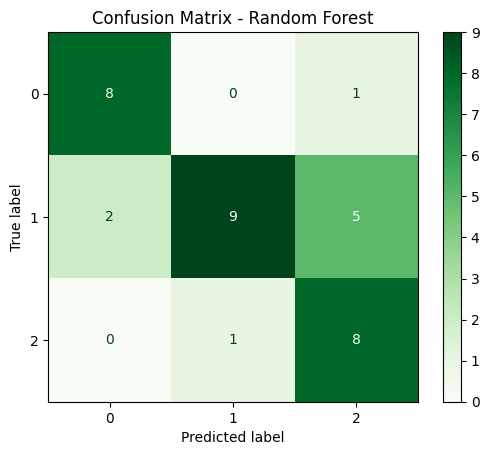

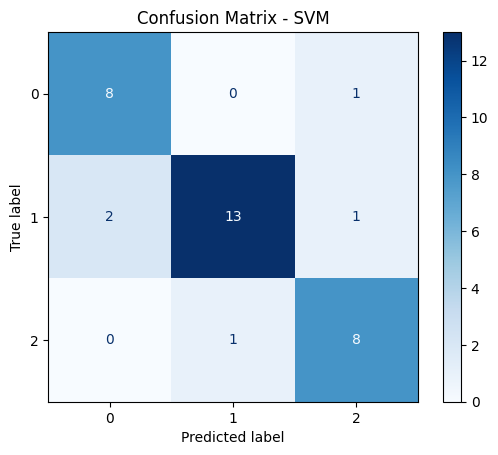

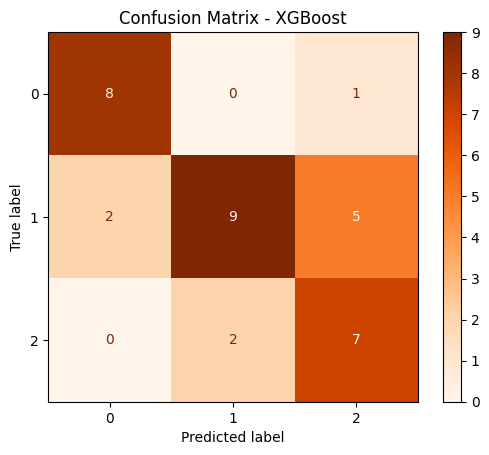

In [68]:


### === Set custom class weights ===
class_weight_dict = {0: 1, 1: 2, 2: 3} #for XGboost
sample_weights = y_train.map(class_weight_dict)

### === Scale only for SVM ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected_RF)
X_test_scaled = scaler.transform(X_test_selected_RF)

### === Define models ===
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
svm = SVC(probability=True, random_state=42, class_weight="balanced")
xgb = XGBClassifier(eval_metric="mlogloss", random_state=42)

### === Hyperparameter grids ===
param_grid_rf = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

param_grid_svm = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.1],
    "kernel": ["rbf", "poly"],
    "degree": [2],  # for poly
    "coef0": [0],   # for poly
}

param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6],
    "learning_rate": [0.01, 0.1],
    "colsample_bytree": [0.8, 1.0],
}

### === Grid search helper ===
def run_grid_search(model, param_grid, X_train, y_train, model_name, sample_weights=None):
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
    if sample_weights is not None:
        grid.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        grid.fit(X_train, y_train)
    print(f"✅ Best Params for {model_name}: {grid.best_params_}")
    return grid.best_estimator_

### === Run grid search ===
best_rf = run_grid_search(rf, param_grid_rf, X_train_selected_RF, y_train, "Random Forest")
best_svm = run_grid_search(svm, param_grid_svm, X_train_scaled, y_train, "SVM")
best_xgb = run_grid_search(xgb, param_grid_xgb, X_train_selected_RF, y_train, "XGBoost", sample_weights)

### === Predict probabilities on test set ===
rf_probs = best_rf.predict_proba(X_test_selected_RF)
svm_probs = best_svm.predict_proba(X_test_scaled)
xgb_probs = best_xgb.predict_proba(X_test_selected_RF)

### === Custom thresholding ===
def predict_with_custom_threshold(probs, thresholds=[0.5, 0.5, 0.2]):
    adjusted_preds = []
    for prob in probs:
        adjusted = [p / t for p, t in zip(prob, thresholds)]
        adjusted_preds.append(np.argmax(adjusted))
    return np.array(adjusted_preds)

rf_preds = predict_with_custom_threshold(rf_probs)
svm_preds = predict_with_custom_threshold(svm_probs)
xgb_preds = predict_with_custom_threshold(xgb_probs)

### === Evaluate models ===
print("🟢 Random Forest:\n", classification_report(y_test, rf_preds))
print("🔵 SVM:\n", classification_report(y_test, svm_preds))
print("🟠 XGBoost:\n", classification_report(y_test, xgb_preds))

### === Confusion Matrices ===
ConfusionMatrixDisplay.from_predictions(y_test, rf_preds, cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, svm_preds, cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, xgb_preds, cmap="Oranges")
plt.title("Confusion Matrix - XGBoost")
plt.show()


##  Model Evaluation Summary (SVM - Best Model)

| Class | Description         | Precision | Recall | F1-Score | Support |
|-------|---------------------|-----------|--------|----------|---------|
| 0     | Activator  | **0.80**      | **0.89**   | **0.84**     | 9       |
| 1     | Weak Inhibitor      | **0.93**      | **0.81**   | **0.87**     | 16      |
| 2     | Potent Inhibitor    | **0.80**      | **0.89**   | **0.84**     | 9       |

**Overall Accuracy:** 85%  
**Macro F1-Score:** 0.85  
**Recall on Potent inhibitors:** **0.89**